<a href="https://colab.research.google.com/github/rutia2044/rutiarbiv-gmail.com/blob/master/Copy_of_%D7%A2%D7%95%D7%AA%D7%A7_%D7%A9%D7%9C_Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import numpy as np
 
import torchvision.transforms as transforms
from torchvision.utils import make_grid
 
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
 
import torch.nn as nn
import torch.nn.functional as F
import torch
 
import os
import glob
 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
from tensorflow import keras,summary
from keras import layers

In [6]:
# number of cpu (in kaggle server)
!cat /proc/cpuinfo | grep processor

processor	: 0
processor	: 1


In [7]:
n_cpu = 2 # number of cpu threads to use during batch generation

In [ ]:
# data (path)
dataset_name = 'gan-getting-started'
root = 'drive/MyDrive/'+dataset_name
 
# data (img)
img_height = 256
img_width = 256
channels = 3
 
# training
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

(256, 256, 3)


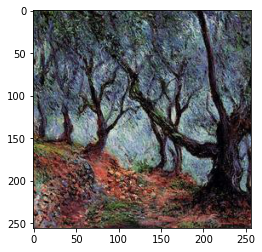

In [ ]:
import cv2
# Load an image using 'imread' specifying the path to image
input2 = cv2.imread('drive/MyDrive/gan-getting-started/monet_jpg/0260d15306.jpg')
# Our file 'input.jpg' is now loaded and stored in python 
# as a variable we named 'image'
# To display our image variable, we use 'imshow'
# The first parameter will be title shown on image window
# The second parameter is the image variable
input = plt.imread('drive/MyDrive/gan-getting-started/monet_jpg/011835cfbf.jpg')
print(input.shape)
plt.imshow(input)
#cv2.imshow(input2)

In [ ]:
#PCA
#Import required modules
from sklearn.decomposition import PCA

digits = load_digits()
data = digits.data
data.shape

#taking a sample image to view
#Remember image is in the form of numpy array.
image_sample = data[0,:].reshape(8,8)
plt.imshow(image_sample)

pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(digits.data)

converted_data.shape


plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = digits.target)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

NameError: ignored

Creating  Distribution for all the monet pictures 

In [ ]:
#from matplotlib import pyplot as plt
import argparse
import cv2
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the image")
#args = vars(ap.parse_args())

# load the input image and convert it to grayscale
image = cv2.imread(root+'monet_jpg/011835cfbf.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# compute a grayscale histogram
#hist = cv2.calcHist([image], [0], None, [256], [0, 256])
plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))

error: ignored

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )
 
    def forward(self, x):
        return x + self.block(x)
 
 
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

In [ ]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [ ]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [ ]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [ ]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

In [ ]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [ ]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
 
transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [ ]:
len(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*'))

300

In [ ]:
len(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*'))

7038

In [ ]:
from torch.utils.data import Dataset
 
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[:30])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[:30])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[30:])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[30:301])
 
    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:


val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

In [ ]:
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        
        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        
# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        
# ------> Total Loss
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real + loss_fake)/2
        
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real + loss_fake)/2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
# -----------------
# Show Progress
# -----------------
        if (i+1) % 10 == 0:
            sample_images()
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))

NameError: ignored

In [ ]:
dataloader2 = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)
print(len(dataloader2.dataset.files_A))
print(len(dataloader2.dataset.files_B))
files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[:30])
print(len(files_A)   )
#arr = np.array(files_A) 
#arr.shape
x = np.array([np.array(Image.open(fname)) for fname in files_A])
x.shape

30
30
30


(30, 256, 256, 3)

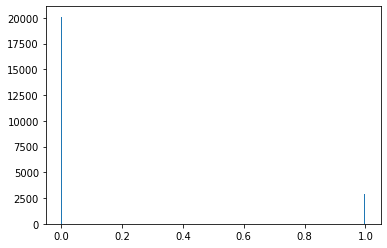

In [ ]:
#np.histogram(x,3)
plt.hist(x.flatten(), bins=256, range=(0, 1))
 
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import keras
from keras import models, layers

In [ ]:
images = []
root = '/content/drive/MyDrive/gan-getting-started/monet_jpg'
for file in tqdm(os.listdir(root)):
    images.append(plt.imread(root+'/'+file))
images = np.array(images)

100%|██████████| 300/300 [02:09<00:00,  2.32it/s]


In [ ]:
images = images/255
print(images[0][0][0][0])

0.6980392156862745


In [25]:
#Encoder
EncoderBaseModel = keras.applications.VGG16(include_top=True,input_shape=(224, 224, 3),weights='imagenet')
EncoderBaseModel.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:

print('----------------*****************------------')
Encoder = keras.models.Model(inputs=EncoderBaseModel.input, outputs = EncoderBaseModel.get_layer('block2_pool').output)
Encoder.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
print("VGG 128")
EncoderBaseModel2 = keras.applications.VGG16(include_top=False,input_shape=(128, 128, 3))
EncoderBaseModel2.summary()
enc2= keras.models.Model(inputs=EncoderBaseModel2.input, outputs = EncoderBaseModel2.get_layer('block2_pool').output)
print("Enc 2")
enc2.summary()

VGG 128
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)     

In [ ]:
#decoder
Decoder=layers.UpSampling2D(size=(2,2))(Encoder.layers[-1].output)
Decoder=layers.Conv2D(kernel_size=(3,3),filters=128,padding='same')(Decoder)
Decoder=layers.Conv2D(kernel_size=(3,3),filters=64,padding='same')(Decoder)
Decoder=layers.UpSampling2D(size=(2,2))(Decoder)
Decoder=layers.Conv2D(kernel_size=(3,3),filters=64,padding='same')(Decoder)
Decoder=layers.Conv2D(kernel_size=(3,3),filters=3 ,padding='same')(Decoder)

NameError: ignored

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import keras
from keras import models, layers

In [13]:
input_img = keras.Input(shape=(256, 256, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)


x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 128)       0   

In [ ]:
images = images/255
print(images[0][0][0][0])

0.6980392156862745


In [ ]:
autoencoder.fit(images, images,
                epochs=10,
                batch_size=1,
                shuffle=True)

Epoch 1/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0107 - accuracy: 0.6414
Epoch 2/10
300/300 [==============================] - 3s 8ms/step - loss: 0.0106 - accuracy: 0.6420
Epoch 3/10
300/300 [==============================] - 3s 8ms/step - loss: 0.0108 - accuracy: 0.6428
Epoch 4/10
300/300 [==============================] - 3s 8ms/step - loss: 0.0109 - accuracy: 0.6485
Epoch 5/10
300/300 [==============================] - 3s 8ms/step - loss: 0.0103 - accuracy: 0.6596
Epoch 6/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0101 - accuracy: 0.6682
Epoch 7/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0102 - accuracy: 0.6651
Epoch 8/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0104 - accuracy: 0.6728
Epoch 9/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0099 - accuracy: 0.6948
Epoch 10/10
300/300 [==============================] - 3s 9ms/step - loss: 0.0099 - accuracy: 0.6953

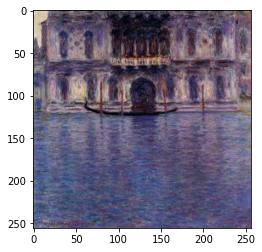

In [ ]:
plt.imshow(images[1])

In [ ]:
print(images[0][0][0][0])

0.6980392156862745


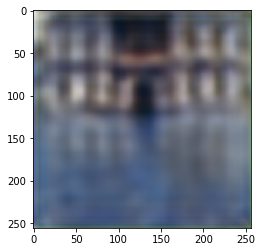

In [ ]:
plt.imshow(autoencoder.predict(images[1].reshape(1, 256, 256, 3))[0])

In [ ]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(images[0].reshape(1, 256, 256, 3))
encoded_imgs.shape

(1, 16, 16, 128)

In [ ]:
encoded_imgs = encoder.predict(images[0:300].reshape(300, 256, 256, 3))
encoded_imgs.shape

(300, 16, 16, 128)

In [ ]:
hist300=np.histogram(encoded_imgs)

In [ ]:
from sklearn.manifold import TSNE
encoded_imgs_reshape = encoded_imgs.reshape(300,16*16*128)

X_embedded = TSNE(n_components=2).fit_transform(encoded_imgs_reshape)
X_embedded.shape

(300, 2)

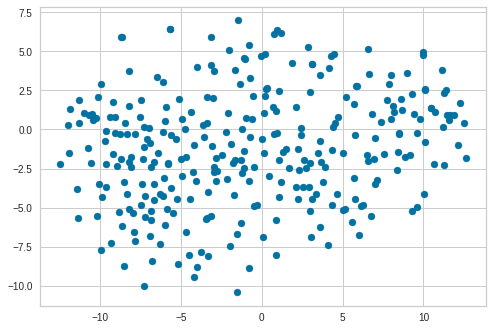

In [ ]:

import matplotlib.pyplot as plt
plt.scatter(X_embedded[:,0:1], X_embedded[:,1:2])
plt.show()

In [ ]:

p = 50
N = 400

print("Building distance matrix...")
d = np.random.rand(N,N) #Random matrix
d = (d + d.T)/2         #Make the matrix symmetric

print("Finding initial edge...")
maxdist  = 0
bestpair = ()
for i in range(N):
  for j in range(i+1,N):
    if d[i,j]>maxdist:
      maxdist = d[i,j]
      bestpair = (i,j)

P = set()
P.add(bestpair[0])
P.add(bestpair[1])

print("Finding optimal set...")
while len(P)<p:
  print("P size = {0}".format(len(P)))
  maxdist = 0
  vbest = None
  for v in range(N):
    if v in P:
      continue
    for vprime in P:
      if d[v,vprime]>maxdist:
        maxdist = d[v,vprime]
        vbest   = v
  P.add(vbest)

print(P) 

In [ ]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Reshape, Concatenate, Lambda, Multiply


class Unpooling(Layer):

    def __init__(self, orig, the_shape, **kwargs):
        self.orig = orig
        self.the_shape = the_shape
        super(Unpooling, self).__init__(**kwargs)

    def call(self, x):
        # here we're going to reshape the data for a concatenation:
        # xReshaped and origReshaped are now split branches
        shape = list(self.the_shape)
        shape.insert(0, 1)
        shape = tuple(shape)
        xReshaped = Reshape(shape)(x)
        origReshaped = Reshape(shape)(self.orig)

        # concatenation - here, you unite both branches again
        # normally you don't need to reshape or use the axis var,
        # but here we want to keep track of what was x and what was orig.
        together = Concatenate(axis=1)([origReshaped, xReshaped])

        bool_mask = Lambda(lambda t: K.greater_equal(t[:, 0], t[:, 1]),
                           output_shape=self.the_shape)(together)
        mask = Lambda(lambda t: K.cast(t, dtype='float32'))(bool_mask)

        x = Multiply()([mask, x])
        return x

In [ ]:

import keras.backend as K
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, ZeroPadding2D, MaxPooling2D
from keras.models import Model

    # Encoder
    input_tensor = keras.Input(shape=(320, 320, 4))
    x = ZeroPadding2D((1, 1))(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_2')(x)
    orig_1 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_2')(x)
    orig_2 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_3')(x)
    orig_3 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_3')(x)
    orig_4 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_3')(x)
    orig_5 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Decoder
    # x = Conv2D(4096, (7, 7), activation='relu', padding='valid', name='conv6')(x)
    # x = BatchNormalization()(x)
    # x = UpSampling2D(size=(7, 7))(x)

    x = Conv2D(512, (1, 1), activation='relu', padding='same', name='deconv6', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_5, (20, 20, 512))(x)

    x = Conv2D(512, (5, 5), activation='relu', padding='same', name='deconv5', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_4, (40, 40, 512))(x)

    x = Conv2D(256, (5, 5), activation='relu', padding='same', name='deconv4', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_3, (80, 80, 256))(x)

    x = Conv2D(128, (5, 5), activation='relu', padding='same', name='deconv3', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_2, (160, 160, 128))(x)

    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv2', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_1, (320, 320, 64))(x)

    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv1', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)

    x = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='pred', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)

    model = Model(inputs=input_tensor, outputs=x)
 print(model.summary())






IndentationError: ignored

In [8]:
images = []
root = 'sample_data/Monet'
for file in tqdm(os.listdir(root)):
    images.append(plt.imread(root+'/'+file))
images = np.array(images)

In [27]:
#images = images/255
print(images[0][0][0][0])

0.7686274509803922


In [26]:
#Encoder
EncoderBaseModel = keras.applications.VGG16(include_top=False,input_shape=(256, 256, 3),weights='imagenet')

In [29]:
#image = preprocess_input(image)
# predict the probability across all output classes
yhat = EncoderBaseModel.predict(images)


TypeError: ignored

In [32]:
yhat.shape
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2).fit_transform( yhat.reshape(300,-1))
tsne.shape


(300, 2)

In [ ]:
from sklearn.cluster

In [11]:
EncoderBaseModel.summary()
print('----------------*****************------------')
print('----------------*****************------------')
print('----------------*****************------------')
Encoder = keras.models.Model(inputs=EncoderBaseModel.input, outputs = EncoderBaseModel.get_layer('block2_pool').output)
Encoder.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [17]:
#Decoder
#Decoder=layers.UpSampling2D(size=(2,2))(Encoder.layers[-1].output)
#Decoder=layers.Conv2D(kernel_size=(3,3),filters=128,padding='same')(Decoder)
#Decoder=layers.Conv2D(kernel_size=(3,3),filters=64,padding='same')(Decoder)
#Decoder=layers.UpSampling2D(size=(2,2))(Decoder)
#Decoder=layers.Conv2D(kernel_size=(3,3),filters=64,padding='same')(Decoder)
#Decoder=layers.Conv2D(kernel_size=(3,3),filters=3 ,padding='same')(Decoder)


Decoder = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(Encoder.layers[-1].output)
Decoder = layers.UpSampling2D((2, 2))(Decoder)
Decoder = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(Decoder)
Decoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(Decoder)
Decoder = layers.UpSampling2D((2, 2))(Decoder)
Decoder = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(Decoder)
Decoder = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(Decoder)


autoencoder = keras.Model(Encoder.layers[0].input, Decoder)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

The following Variables were used a Lambda layer's call (tf.nn.convolution_5), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_15/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_5), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_15/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_6), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_16/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is in

In [18]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Defining simple method with two arguments, i.e. our image and our model  
def get_features(image,model):  
#choosing specific layer within our VGG-19 model that we are going to extract features from   
# Defining layers dictionary object which contains the specific layers    
  layers={'0':'conv1_1', #Mapping 0 to conv1_1  
          '5':'conv2_1', #Mapping 5 to conv2_1  
          '10':'conv3_1', #Mapping 10 to conv3_1  
          '19':'conv4_1', #Mapping 19 to conv4_1  
          '21':'conv4_2', #Mapping 21 to conv4_2  
          '28':'conv5_1',} #Mapping 28 to conv5_1 
          #Defining an empty dictionary called features to store all the extracted features   
features={}  
  #Running a loop which iterates over all of the layers in our model   
  for name, layer in model._modules.items():   
    #Running our image through the specific layer and store into the new image  
    image=layer(image)  
    #checking the name of the current layer which we are iterating through is inside layers  
    if name in layers:  
      #If true then store the output from that specific layer   
      features[layers[name]]=image   
  #returning feature dictionary   
  return features  